In [1]:
%matplotlib widget
import psycopg2
import numpy as np
import gower
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm.notebook import tqdm

from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

# Loading data

## Querying database

In [2]:
# Loading data
conn = psycopg2.connect(database="full_STUPS",
                        user="postgres",
                        host='localhost',
                        password="postgres",
                        port=5432)
cur = conn.cursor()
cur.execute( '''select distinct ep.*, id_lot
                from echantillon_propriete ep 
                inner join echantillon e on e.id = ep.id 
                inner join composition c on c.id = e.id_composition 
                inner join lot_complet lc on (lc.e1 = c.id or lc.e2 = c.id)
                order by id_lot''')
samples = cur.fetchall()
conn.commit()
conn.close()
colnames = [desc[0] for desc in cur.description]

## Preparing dataset

In [3]:
quanti_cols = ['epaisseur', 'epaisseur', 'hauteur', 'diametre', 'largeur', 'longueur', 'masse', '_3_4_methylene_dioxy_methylamphetamine', '_3_4_methylenedioxyethylamphetamine', '_3_4_methylenedioxyphenylacetone', '_4f_mdmb_butinaca', '_5f_adb', '_5f_mdmb_pica', 'acetylcodeine', 'acetylthebaol', 'acide_4_hydroxybutanoique', 'acide_benzoique', 'acide_borique', 'adb_butinaca', 'amidon', 'aminopyrine', 'amoxycilline', 'amphetamine', 'benzocaine', 'benzoylecgonine', 'bicarbonate_de_sodium', 'bicarbonates', 'buprenorphine', 'cafeine', 'cannabidiol', 'cannabigerol', 'cannabinol', 'cis_cinnamoylcocaine', 'clonazepam', 'clotrimazole', 'cocaine', 'codeine', 'creatine', 'delta8_tetrahydrocannabinol', 'delta9_tetrahydrocannabinol', 'dextromethorphane', 'diltiazem', 'dimethylterephtalate', 'diphenydramine', 'ecgonidine', 'ecgoninemethylester', 'fub_amb', 'gammabutyrolactone', 'glucose', 'griseofulvine', 'guaifenesine', 'heroine', 'hydroxyzine', 'ibuprofene', 'inositol', 'isoleucine', 'ketamine', 'lactitol', 'lactose', 'leucine', 'levamisole', 'lidocaine', 'maltose', 'mannitol', 'mdmb_4en_pinaca', 'meconine', 'methamphetamine', 'methylecgonidine', 'monoacetylmorphine', 'morphine', 'n_methyl_tryptamine', 'nicotine', 'norcocaine', 'noscapine', 'o3_monoacetylmorphine', 'o6_monoacetylmorphine', 'oxycodone', 'papaverine', 'paracetamol', 'phenacetine', 'piracetam', 'procaine', 'pv8', 'saccharose', 'sorbitol', 'talc', 'taux_cbd', 'taux_cbn', 'terephtalates', 'tetracaine', 'tramadol', 'trans_cinnamoylcocaine', 'tropacocaine', 'uree', 'valine', 'vanilline']
quali_cols = ['abime','cbd','cbn','couleur','couleur_exterieur','couleur_exterieur_1','couleur_exterieur_2','couleur_interieur','etiquette','forme','logo','ovule','secabilite_recto','secabilite_verso','type_drogue','visqueux','presentation']

X = pd.DataFrame(list(samples), columns=colnames) 
X = X.drop(columns=['id', 'id_lot', 'description_de_l_objet', 'numero_echantillon'])

quanti_X = X[quanti_cols].fillna(0).astype(float)
quali_X = X[quali_cols]
X = pd.concat([quanti_X, quali_X], axis=1)

print(f'Samples shape : {X.shape}')

Samples shape : (1861, 113)


# Computing Gower distance

In [4]:
# Computing distance matrix between all samples
dist_matrix = gower.gower_matrix(X)
print(f'Distance matrix size : {dist_matrix.size}')

Distance matrix size : 3463321


# Computing t-SNE

In [5]:
# Computing t-SNE
tsne = TSNE(n_components=3,
            init='random',
            metric='precomputed',
            random_state=100)
embedding = tsne.fit_transform(dist_matrix)

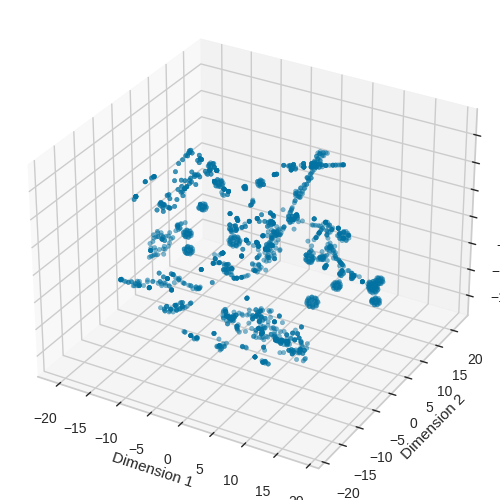

In [6]:
# Printing t-SNE results
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, auto_add_to_figure=False)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
fig.add_axes(ax)

# plot
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=10, marker='o',  alpha=0.5)

# Looking for the optimal number of clusters

In [7]:
min_clusters = 2
nb_clusters = 200
nb_clusters_range = range(min_clusters, nb_clusters + min_clusters)

## Computing elbow score for *k* different number of clusters

In [8]:
# Computing different clustering silhouette score
# using kmenoids with different number of clusters
inertia = []

for i in tqdm(nb_clusters_range):
    model = KMedoids(n_clusters=i, init='k-medoids++').fit(embedding)
    inertia.append(model.inertia_)

inertia_derivative = np.gradient(inertia)
curvature = np.gradient(inertia_derivative)

  0%|          | 0/200 [00:00<?, ?it/s]

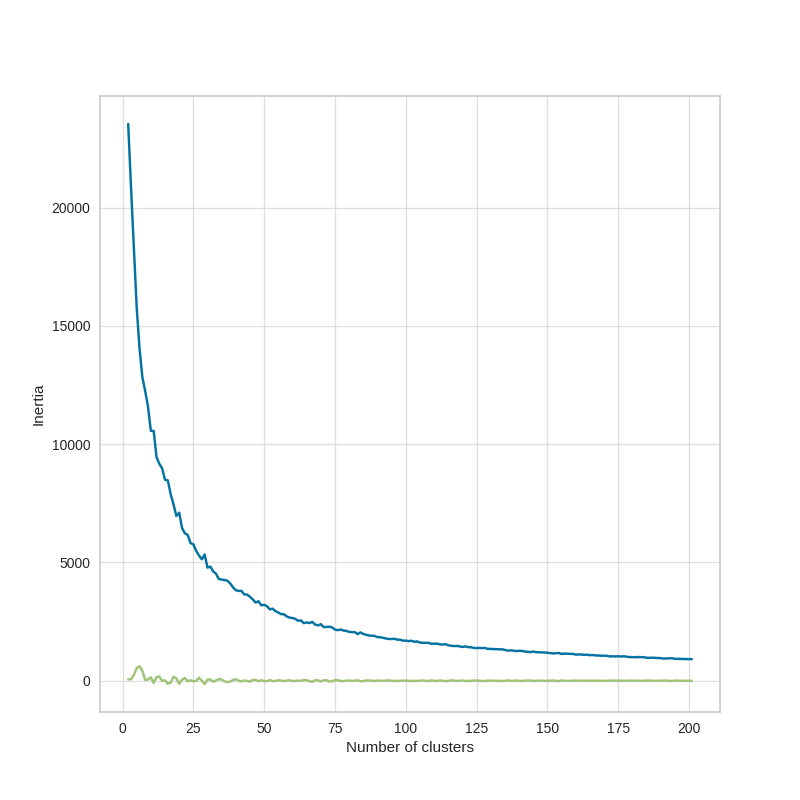

In [9]:
# Printing elbow curve(s)
fig = plt.figure(figsize=(8, 8))
plt.plot(nb_clusters_range, inertia)
plt.plot(nb_clusters_range, curvature)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.grid(visible=True, alpha=0.6)
plt.show()

## Computing silhouette score *k* different number of clusters

In [10]:
# Computing different clustering silhouette score
# using kmenoids with different number of clusters 
labels_results = []
silhouette_scores = []

for i in tqdm(nb_clusters_range):
    model = KMedoids(n_clusters=i, init='k-medoids++').fit(embedding)
    cluster_labels = model.labels_
    silhouette_avg = silhouette_score(embedding, cluster_labels)
    labels_results.append(cluster_labels)
    silhouette_scores.append(silhouette_avg)

  0%|          | 0/200 [00:00<?, ?it/s]

## Silhouette score curve

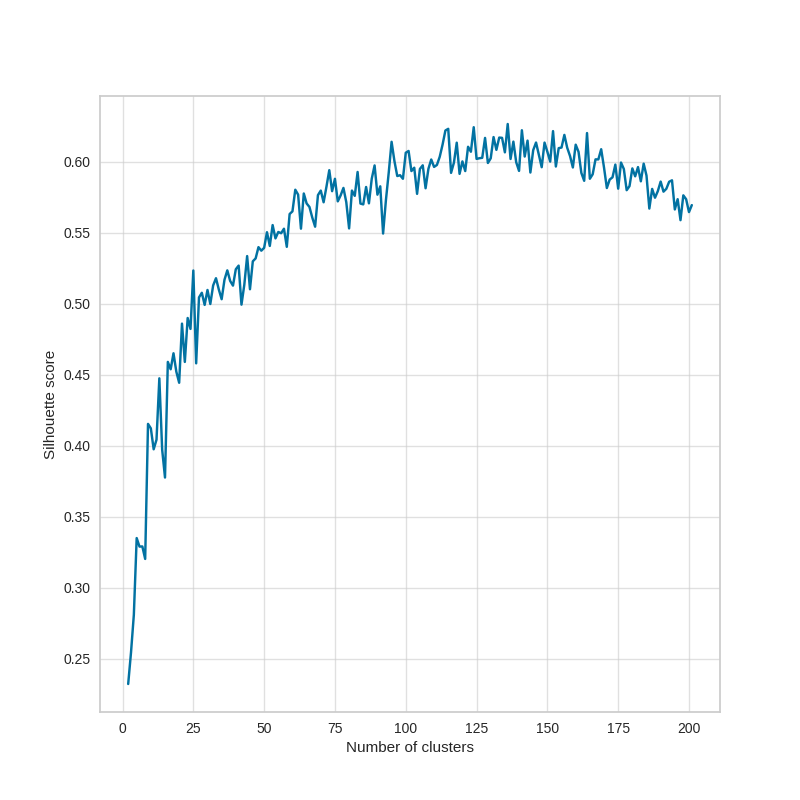

In [11]:
# Printing silhouette curve(s)
fig = plt.figure(figsize=(8, 8))
plt.plot(nb_clusters_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

plt.grid(visible=True, alpha=0.6)
plt.show()

# Selecting optimal number of clusters

In [12]:
# Finding the optimal cluster number
index_cluster = np.argmax(silhouette_scores)
optimal_hyperparameter_number = index_cluster + 1 # Indexes start at 0.
print(f'Optimal number of clusters : {optimal_hyperparameter_number}.')

Optimal number of clusters : 135.


# Printing cluster

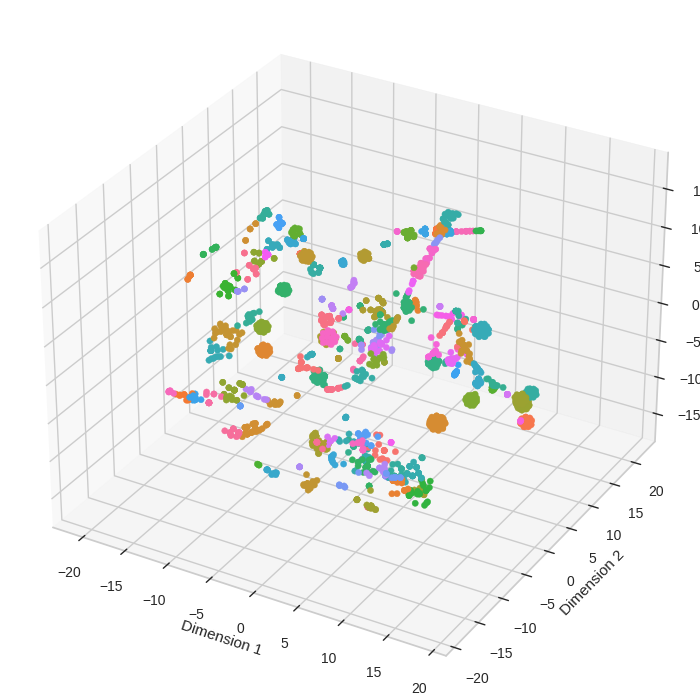

In [13]:
# Printing the cluster according to the optimal cluster number
cluster_labels = labels_results[optimal_hyperparameter_number]
embedding_df = pd.DataFrame({'x': embedding[:, 0],
                             'y': embedding[:, 1],
                             'z': embedding[:, 2],
                             'label': cluster_labels})

# axes instance
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, auto_add_to_figure=False)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", len(np.unique(cluster_labels))).as_hex())

# plot
sc = ax.scatter(embedding_df.loc[:, 'x'], embedding_df.loc[:, 'y'], embedding_df.loc[:, 'z'], s=20, c=embedding_df.loc[:, 'label'], marker='o', cmap=cmap, alpha=1)

# Evaluating results

TODO (?)